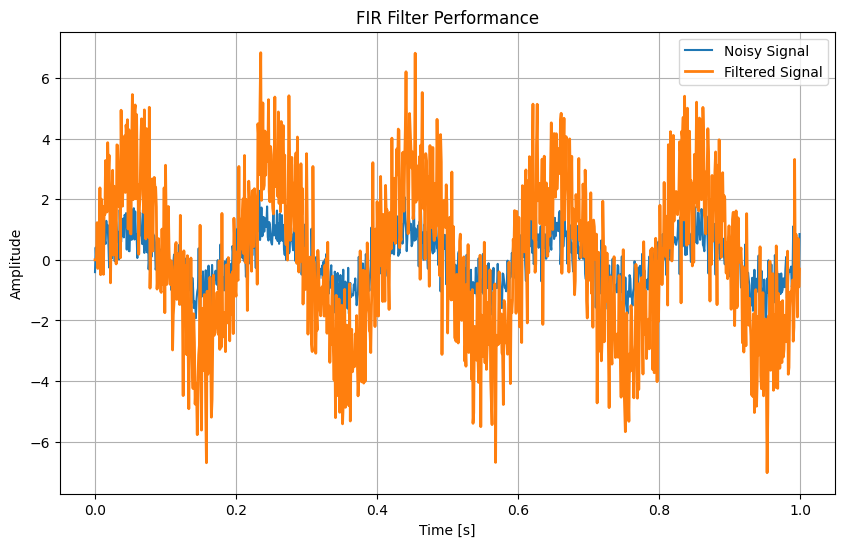

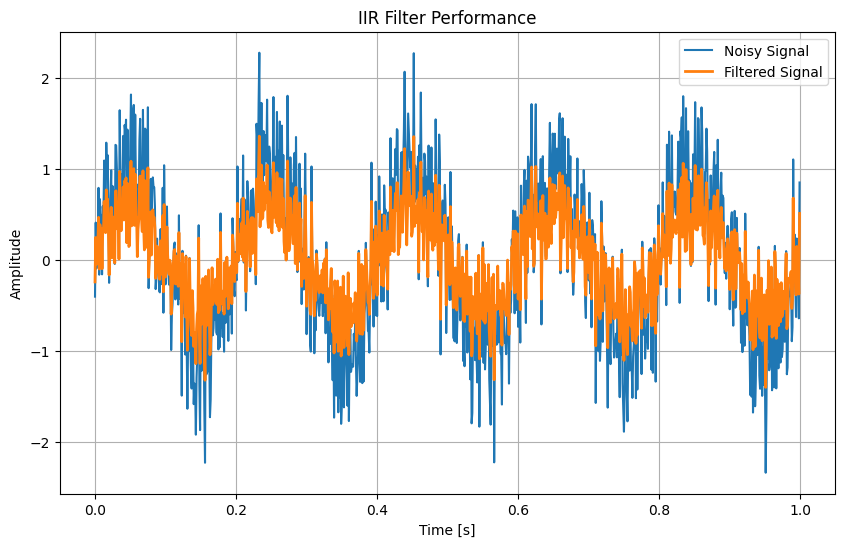

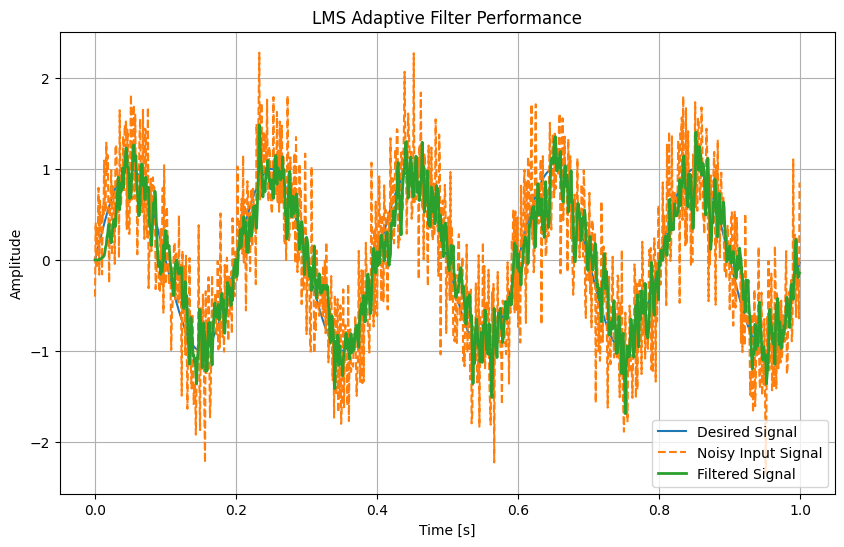

In [4]:
import numpy as np
import matplotlib.pyplot as plt


fs = 1000
t = np.linspace(0, 1, fs, endpoint=False)
clean_signal = np.sin(2 * np.pi * 5 * t) 

noisy_signal = clean_signal + 0.5 * np.random.randn(len(t)) 

# --- FIR Filter Implementation (Section 5.1 from Lab Manual) ---
# This section implements a Finite Impulse Response (FIR) filter using the provided
# fir_filter function and applies the coefficients for Variant 3.
# The performance of the filter in reducing noise from the noisy sinusoidal signal is then visualized.

def fir_filter(x, b):
    """
    FIR filter implementation.

    Parameters:
    x : ndarray
        Input signal.
    b : ndarray
        Filter coefficients.

    Returns:
    y : ndarray
        Filtered output signal.
    """
    M = len(b)
    y = np.zeros(len(x))
    # Loop starts from M to ensure x[n-k] for all k in b is within bounds [0, len(x)-1]
    # This implicitly assumes x[k]=0 for k<0.
    for n in range(M, len(x)):
        # Direct implementation of y[n] = sum(b[k] * x[n-k])
        # x[n-M+1:n+1][::-1] correctly gets x[n], x[n-1], ..., x[n-M+1]
        y[n] = np.dot(b, x[n-M+1:n+1][::-1])
    return y

# Variant 3: FIR Filter Coefficients
b_fir = np.array([0, 0, 3]) 

# Apply FIR filter
filtered_fir_signal = fir_filter(noisy_signal, b_fir)

# Plotting FIR filter results
plt.figure(figsize=(10, 6))
plt.plot(t, noisy_signal, label="Noisy Signal")
plt.plot(t, filtered_fir_signal, label="Filtered Signal", linewidth=2)
plt.legend()
plt.title("FIR Filter Performance")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


# --- IIR Filter Implementation (Section 5.2 from Lab Manual) ---
# This section implements an Infinite Impulse Response (IIR) filter using the provided
# iir_filter function and applies the coefficients for Variant 3.
# The filter's ability to reduce noise in the same noisy sinusoidal signal is then evaluated through a plot.

def iir_filter(x, b, a):
    """
    IIR filter implementation.

    Parameters:
    x : ndarray
        Input signal.
    b : ndarray
        Numerator coefficients.
    a : ndarray
        Denominator coefficients.

    Returns:
    y : ndarray
        Filtered output signal.
    """
    M = len(b)        # Numerator order (or len(b) taps)
    N_den = len(a)    # Denominator order (or len(a) taps)
    y = np.zeros(len(x)) # Output signal, initialized to zeros

    # Ensure a[0] is 1 for standard IIR form (H(z) = B(z)/A(z) where A(z) starts with 1)
    # If a[0] is not 1, we should normalize coefficients
    # This scenario is common in some definitions but not strictly required if a[0] is always 1 in inputs.
    # The variant 3 a = [1, 0.5, 0.2] already has a[0]=1.
    if a[0] != 1.0:
        # Normalize b and a by a[0] if a[0] is not 1
        b = b / a[0]
        a = a / a[0]

    for n in range(len(x)):
        # Calculate the FIR part (numerator)
        # y[n] += b[0]*x[n] + b[1]*x[n-1] + ... + b[M-1]*x[n-M+1]
        for k_b in range(M):
            if (n - k_b) >= 0: # Check to ensure index is within bounds (x[k]=0 for k<0)
                y[n] += b[k_b] * x[n - k_b]

        # Calculate the IIR part (denominator feedback)
        # y[n] -= a[1]*y[n-1] + a[2]*y[n-2] + ... + a[N_den-1]*y[n-N_den+1]
        for k_a in range(1, N_den): # Start from index 1 for 'a' coefficients (a[0] is for y[n])
            if (n - k_a) >= 0: # Check to ensure index is within bounds (y[k]=0 for k<0)
                y[n] -= a[k_a] * y[n - k_a]
                
    return y

# Variant 3: IIR Filter Coefficients
b_iir = np.array([0.6, 0.3, 0.1])
a_iir = np.array([1, 0.5, 0.2])

# Apply IIR filter
filtered_iir_signal = iir_filter(noisy_signal, b_iir, a_iir)

# Plotting IIR filter results
plt.figure(figsize=(10, 6))
plt.plot(t, noisy_signal, label="Noisy Signal")
plt.plot(t, filtered_iir_signal, label="Filtered Signal", linewidth=2)
plt.legend()
plt.title("IIR Filter Performance")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


# --- Adaptive LMS Filter Implementation (Section 5.3 from Lab Manual) ---
# This section implements the Least Mean Squares (LMS) adaptive filter using the provided
# lms_filter function. It applies the parameters for Variant 3 to reduce noise,
# taking a clean sinusoidal signal as the desired output and the noisy signal as the input.

def lms_filter(x, d, mu, num_taps):
    """
    LMS adaptive filter implementation.

    Parameters:
    x : ndarray
        Input signal (noisy).
    d : ndarray
        Desired signal.
    mu : float
        Step size.
    num_taps : int
        Number of filter taps.

    Returns:
    y : ndarray
        Filtered output signal.
    e : ndarray
        Error signal.
    W : ndarray
        Final filter weights.
    """
    n_samples = len(x)
    W = np.zeros(num_taps)  # Initial filter weights, all zeros
    y = np.zeros(n_samples) # Filtered output signal (initialized to zeros)
    e = np.zeros(n_samples) # Error signal (initialized to zeros)

    for i in range(num_taps, n_samples):
        # Current input segment for filter (x[n], x[n-1], ..., x[n-M+1])
        # x[i-num_taps:i] gives the segment of length num_taps ending at index i-1.
        # [::-1] reverses it to match typical dot product convention (w_0*x_n + w_1*x_n-1 + ...)
        x_segment = x[i - num_taps : i][::-1] 
        
        y[i] = np.dot(W, x_segment) # Filter output: y[n] = w[n]^T * x[n]
        e[i] = d[i] - y[i] # Error calculation: e[n] = d[n] - y[n]
        W += mu * e[i] * x_segment # Weight update rule: w[n+1] = w[n] + mu * e[n] * x[n]

    return y, e, W

# Variant 3: LMS Adaptive Filter Parameters
mu_lms = 0.05 
num_taps_lms = 4

# Apply LMS adaptive filter
# 'clean_signal' is used as 'd' (desired signal)
# 'noisy_signal' is used as 'x' (input signal)
filtered_lms_signal, error_lms_signal, final_weights_lms = lms_filter(noisy_signal, clean_signal, mu_lms, num_taps_lms)

# Plotting LMS filter results
plt.figure(figsize=(10, 6))
plt.plot(t, clean_signal, label="Desired Signal") # Show desired signal for comparison
plt.plot(t, noisy_signal, label="Noisy Input Signal", linestyle='--')
plt.plot(t, filtered_lms_signal, label="Filtered Signal", linewidth=2)
plt.legend()
plt.title("LMS Adaptive Filter Performance")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()